# Brute-force pretrained model on Invasive species classification

- The model relies on VGG-16 pretrained model, with `include_top=False`. On top of that, a nn with (1) Dense layer 256 neurons, (2) Output layer 1 neuron, with sigmoid classification.
- This model is brutal, in the sense that, all paramaters including vgg-16, are trainable. This makes the model too heavy to train, (2~3 days on a 4-core desktop!)
- Data augmentation is applied upon traing every batch.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys

In [2]:
master = pd.read_csv("../input/train_labels.csv")
master.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [3]:
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
print('fnames: {}'.format(file_paths[:10]))
print('labels: {}'.format(y[:10]))

fnames: ['../input/train/1.jpg', '../input/train/2.jpg', '../input/train/3.jpg', '../input/train/4.jpg', '../input/train/5.jpg', '../input/train/6.jpg', '../input/train/7.jpg', '../input/train/8.jpg', '../input/train/9.jpg', '../input/train/10.jpg']
labels: [0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


In [4]:
y = np.array(y)

#### This group of functions perfrom preprocessing of input training images

- `centering_image`: input `img` has max size 256, and the other dim < 256. This function does zero_padding to make the `img` to size 256 x 256 x 3
- The input raw image is first resized by the same percentage in col and row, the output image is feed to `cetering_image`
- After that, the img is cropped to size 224 x 224 x 3

In [5]:
#image resize & centering & crop 

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized


X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size)

    #centering
    img = centering_image(img)

    #out put 224*224px 
    img = img[16:240, 16:240]

    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

Let's take a look at an example walking through the process of image preprocessing.

(866, 1154, 3)


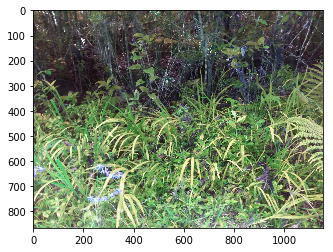

In [6]:
file_path = '../input/train/1.jpg'
img = cv2.imread(file_path)
print(img.shape); plt.imshow(img); plt.show()

Change default BGR from `cv2.imread` to RGB format.

(866, 1154, 3)


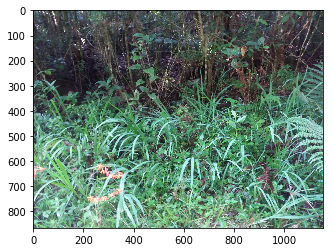

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
print(img.shape); plt.imshow(img); plt.show()

(192, 256, 3)


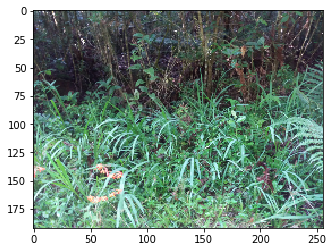

In [8]:
#resize
if(img.shape[0] > img.shape[1]):
    tile_size = (int(img.shape[1]*256/img.shape[0]),256)
else:
    tile_size = (256, int(img.shape[0]*256/img.shape[1]))

img = cv2.resize(img, dsize=tile_size)
print(img.shape); plt.imshow(img); plt.show()

(256, 256, 3)


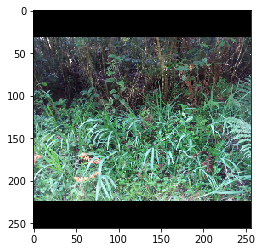

In [9]:
#centering
img = centering_image(img)
print(img.shape); plt.imshow(img); plt.show()

(224, 224, 3)


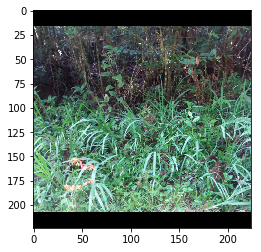

In [10]:
#out put 224*224px 
img = img[16:240, 16:240]
print(img.shape); plt.imshow(img); plt.show()

Find all test image file path_file names.

In [11]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
img_path = "../input/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i,0])
    file_paths.append( img_path + str(int(sample_submission.iloc[i,0])) +'.jpg' )

print('test file path: {}'.format(file_paths[:10]))    
test_names = np.array(test_names)

test file path: ['../input/test/1.jpg', '../input/test/2.jpg', '../input/test/3.jpg', '../input/test/4.jpg', '../input/test/5.jpg', '../input/test/6.jpg', '../input/test/7.jpg', '../input/test/8.jpg', '../input/test/9.jpg', '../input/test/10.jpg']


Test images are done with exactly the same preprocessing scheme.

In [12]:
test_images = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()

    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))
    
    #out put 224*224px 
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images)

 ../input/test/1531.jpg from total 1531 images

Train-test splitting.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


Normalizing.

In [14]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255

### Using Keras VGG-16 pretrained model

In [15]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_rows, img_cols, img_channel))

Using TensorFlow backend.


In [16]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
layer_pred = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=layer_pred)
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 40

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)


history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)])

Epoch 1/40
119s - loss: 0.4737 - acc: 0.7697 - val_loss: 0.4114 - val_acc: 0.8017
Epoch 2/40
109s - loss: 0.2944 - acc: 0.8768 - val_loss: 0.2008 - val_acc: 0.9325
Epoch 3/40
106s - loss: 0.2107 - acc: 0.9097 - val_loss: 0.1485 - val_acc: 0.9434
Epoch 4/40
106s - loss: 0.1941 - acc: 0.9176 - val_loss: 0.1606 - val_acc: 0.9455
Epoch 5/40
106s - loss: 0.1781 - acc: 0.9287 - val_loss: 0.1415 - val_acc: 0.9586
Epoch 6/40
106s - loss: 0.1713 - acc: 0.9382 - val_loss: 0.1065 - val_acc: 0.9673
Epoch 7/40
105s - loss: 0.1340 - acc: 0.9490 - val_loss: 0.1472 - val_acc: 0.9586
Epoch 8/40
105s - loss: 0.1656 - acc: 0.9421 - val_loss: 0.1303 - val_acc: 0.9630
Epoch 9/40
105s - loss: 0.1254 - acc: 0.9589 - val_loss: 0.1128 - val_acc: 0.9521
Epoch 10/40
106s - loss: 0.1154 - acc: 0.9602 - val_loss: 0.0808 - val_acc: 0.9760
Epoch 11/40
105s - loss: 0.1032 - acc: 0.9671 - val_loss: 0.0813 - val_acc: 0.9739
Epoch 12/40
105s - loss: 0.1043 - acc: 0.9600 - val_loss: 0.1003 - val_acc: 0.9717
Epoch 13/40
1

make prediction on test data set.

In [19]:
test_images = test_images.astype('float32')
test_images /= 255

In [20]:
model = load_model('VGG16-transferlearning.model')
predictions = model.predict(test_images)

In [21]:
predictions[:10]

array([[ 0.99999499],
       [ 0.00565602],
       [ 0.0117678 ],
       [ 0.00225612],
       [ 0.99998844],
       [ 0.05878787],
       [ 0.01838201],
       [ 1.        ],
       [ 1.        ],
       [ 0.00142461]], dtype=float32)

Output test set prediction to file.

In [22]:
sample_submission = pd.read_csv("../input/sample_submission.csv")

for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]

sample_submission.to_csv("submit.csv", index=False)

Above is just a working example of applying the vgg-16 pretrain model to make predictions on the invasive dataset. Only 200 samples of the training set and 100 samples of the test set has been used. It is amazing that the prediction accuracy could achieve around 70%.